In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')


In [27]:
def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    print("Train shape:", train.shape)
    print("Test shape:", test.shape)
    return train, test


In [28]:
def perform_eda(df):
    print(df.describe())
    print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))

    # Target distribution
    sns.histplot(df['SalePrice'], kde=True)
    plt.title("SalePrice Distribution")
    plt.show()

    # Log-transformed target
    sns.histplot(np.log1p(df['SalePrice']), kde=True)
    plt.title("Log-transformed SalePrice")
    plt.show()

    # 🔧 Fix: Select only numeric columns for correlation
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    top_corr = corr['SalePrice'].sort_values(ascending=False).head(20) #Picks the top 20 features most correlated with SalePrice.

    sns.barplot(x=top_corr.values, y=top_corr.index)
    plt.title("Top 20 Correlated Features with SalePrice")
    plt.show()


In [29]:
def preprocess_data(train, test):
    train['source'] = 'train'
    test['source'] = 'test'
    test['SalePrice'] = np.nan
    
    full_data = pd.concat([train, test], axis=0)
    
    # Drop columns with too many missing values or irrelevant
    drop_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Id']
    full_data.drop(columns=drop_cols, inplace=True)
    
    # Fill missing values
    for col in full_data.select_dtypes(include=['object']).columns:
        full_data[col] = full_data[col].fillna('None')
    
    for col in full_data.select_dtypes(include=['number']).columns:
        full_data[col] = full_data[col].fillna(full_data[col].median())
    
    # One-hot encode categorical variables
    full_data = pd.get_dummies(full_data)
    
    # Split back
    train_cleaned = full_data[full_data['source_train'] == 1].drop(['source_train', 'source_test'], axis=1)
    test_cleaned = full_data[full_data['source_test'] == 1].drop(['SalePrice', 'source_train', 'source_test'], axis=1)
    
    return train_cleaned, test_cleaned


In [30]:
def clean_data(train, test):
    train['source'] = 'train'
    test['source'] = 'test'
    test['SalePrice'] = np.nan
    full = pd.concat([train, test], axis=0)

    drop_cols = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
    full.drop(columns=drop_cols, inplace=True)

    # Fill missing values
    for col in full.select_dtypes(include=['object']).columns:
        full[col] = full[col].fillna("None")
    for col in full.select_dtypes(include=['number']).columns:
        full[col] = full[col].fillna(full[col].median())

    return full



In [31]:
def encode_and_scale(full):
    full = pd.get_dummies(full)

    scaler = StandardScaler()
    numerical = full.select_dtypes(include=['float64', 'int64']).columns
    full[numerical] = scaler.fit_transform(full[numerical])

    return full


In [32]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def remove_multicollinearity(X, threshold=10):
    # 1. Keep only numeric columns
    X_numeric = X.select_dtypes(include=[np.number]).copy()
    
    # 2. Drop rows with missing values (or impute as needed)
    X_numeric = X_numeric.dropna()
    
    # 3. Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
    
    # 4. Find features to drop with VIF > threshold
    drop_cols = vif_data[vif_data["VIF"] > threshold]["feature"].tolist()
    
    print(f"Dropping {len(drop_cols)} features due to high VIF: {drop_cols}")
    
    # 5. Drop these columns from original X (not just numeric subset)
    return X.drop(columns=drop_cols, errors='ignore')


In [33]:
def apply_pca(X, n_components=100):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca


In [34]:
def prepare_train_test(full_encoded):
    train = full_encoded[full_encoded['SalePrice'].notnull()]
    test = full_encoded[full_encoded['SalePrice'].isnull()].drop('SalePrice', axis=1)

    X = train.drop("SalePrice", axis=1)
    y = train["SalePrice"]

    # Split into train-validation
    X_train_val, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train_val, X_val, y_train, y_val, test


In [63]:
from sklearn.metrics import mean_squared_error, confusion_matrix

def evaluate_model(model, X_train, X_val, y_train_log, y_val_log):
    model.fit(X_train, y_train_log)
    preds_log = model.predict(X_val)
    
    # Calculate RMSE in log scale
    rmse = np.sqrt(mean_squared_error(y_val_log, preds_log))
    print(f"{model.__class__.__name__} RMSE: {rmse:.4f}")

    # Convert predictions and actual back to original scale
    preds = np.expm1(preds_log)
    actual = np.expm1(y_val_log)
    
    # Create quantile bins with duplicate edges dropped
    actual_bins = pd.qcut(actual, 4, labels=False, duplicates='drop')
    pred_bins = pd.qcut(preds, 4, labels=False, duplicates='drop')

    # Compute confusion matrix
    cm = confusion_matrix(actual_bins, pred_bins)
    print("Confusion Matrix:")
    print(cm)


In [64]:
def train_all_models(X_train, X_val, y_train, y_val):
    models = [
        LinearRegression(),
        Ridge(alpha=0.0001),
        Lasso(alpha=0.001),
        RandomForestRegressor(n_estimators=100, random_state=42),
        GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    ]
    for model in models:
        evaluate_model(model, X_train, X_val, y_train, y_val)


In [56]:
!pip install xgboost

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-win_amd64.whl (124.9 MB)


In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def train_all_models(X_train, X_val, y_train, y_val):
    models = [
        ('LinearRegression', LinearRegression(), None),
        ('Ridge', Ridge(), {'alpha': [0.0001, 0.001, 0.01, 0.1]}),
        ('Lasso', Lasso(), {'alpha': [0.0001, 0.001, 0.01]}),
        ('RandomForestRegressor', RandomForestRegressor(random_state=42), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
        ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42), {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}),
        ('XGBRegressor', XGBRegressor(random_state=42, verbosity=0, eval_metric='rmse'), 
         {'n_estimators': [100, 200], 'learning_rate': [0.001], 'max_depth': [12, 20]})
    ]

    for name, model, param_grid in models:
        print(f"\nTraining {name}...")

        if param_grid is not None:
            grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"Best params for {name}: {grid.best_params_}")
            evaluate_model(best_model, X_train, X_val, y_train, y_val)
        else:
            model.fit(X_train, y_train)
            evaluate_model(model, X_train, X_val, y_train, y_val)


In [68]:
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_train, X_val, y_train, y_val):
    # Train model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_val)
    
    # Calculate RMSE
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"{model.__class__.__name__} RMSE: {rmse:.4f}")
    
    # ---- REMOVE confusion matrix if regression ----
    # If you still want confusion matrix, convert continuous to classes first:
    # For example, bin target and prediction into 4 classes by quartiles
    bins = np.quantile(y_val, [0, 0.25, 0.5, 0.75, 1])
    y_val_binned = np.digitize(y_val, bins) - 1
    y_pred_binned = np.digitize(y_pred, bins) - 1
    
    cm = confusion_matrix(y_val_binned, y_pred_binned)
    print("Confusion Matrix:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()



Training LinearRegression...
LinearRegression RMSE: 10119593543.9619
Confusion Matrix:
[[  0   0   0   0   0]
 [  2  99  14  22   1]
 [  3 177  13 106   1]
 [  1   3   4 135   2]
 [  0   0   0   1   0]]


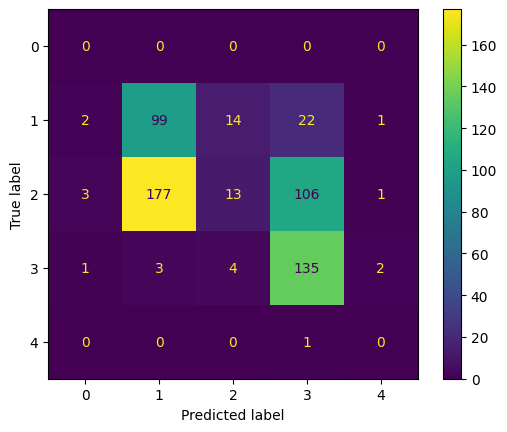


Training Ridge...
Best params for Ridge: {'alpha': 0.1}
Ridge RMSE: 0.8031
Confusion Matrix:
[[101  13  24   0]
 [177  13 110   0]
 [  3   6 136   0]
 [  0   0   1   0]]


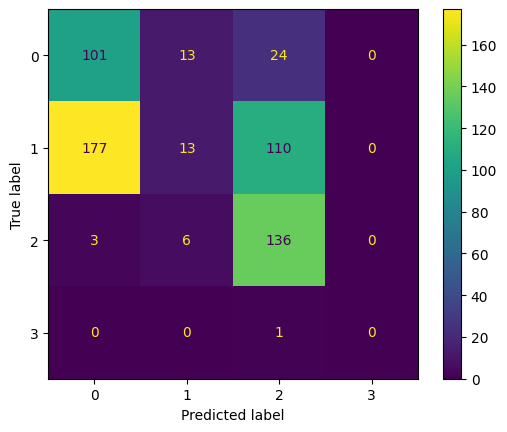


Training Lasso...
Best params for Lasso: {'alpha': 0.01}
Lasso RMSE: 0.8096
Confusion Matrix:
[[108   8  22   0]
 [171  18 111   0]
 [  1   4 140   0]
 [  0   0   1   0]]


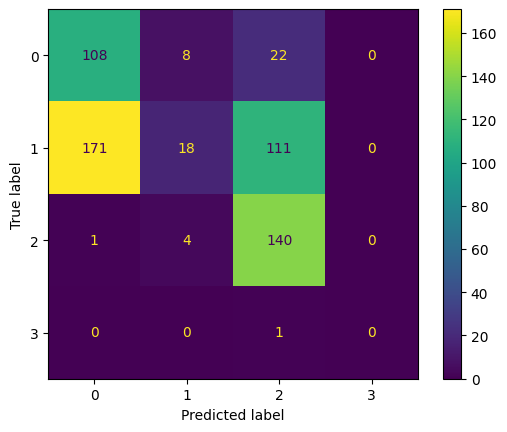


Training RandomForestRegressor...
Best params for RandomForestRegressor: {'max_depth': 20, 'n_estimators': 100}
RandomForestRegressor RMSE: 0.3932
Confusion Matrix:
[[127   3   8   0]
 [181 116   3   0]
 [  6   5 134   0]
 [  0   0   1   0]]


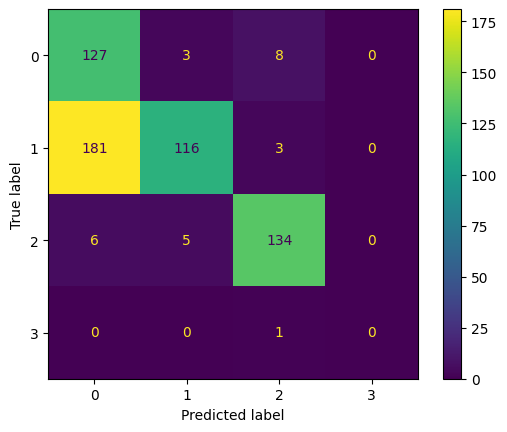


Training GradientBoostingRegressor...
Best params for GradientBoostingRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
GradientBoostingRegressor RMSE: 0.3996
Confusion Matrix:
[[130   4   4   0]
 [165  90  45   0]
 [  8   6 131   0]
 [  0   0   1   0]]


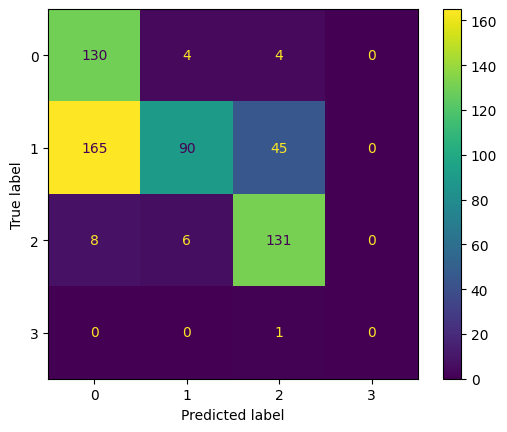


Training XGBRegressor...
Best params for XGBRegressor: {'learning_rate': 0.001, 'max_depth': 12, 'n_estimators': 200}
XGBRegressor RMSE: 0.9254
Confusion Matrix:
[[ 47  67  24   0]
 [  0   1 299   0]
 [  0   6 139   0]
 [  0   0   1   0]]


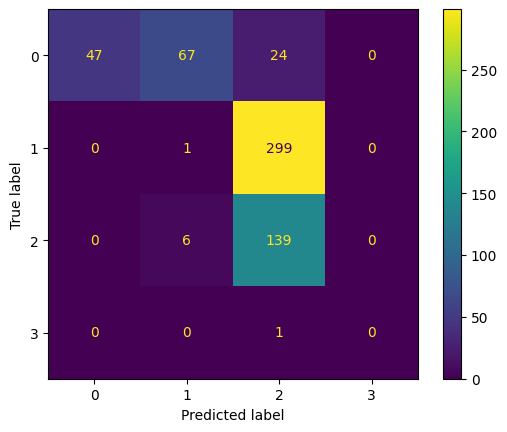

In [69]:
train_all_models(X_train_val, X_val, y_train, y_val)

In [74]:
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_train, X_val, y_train, y_val):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Calculate RMSE
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"{model.__class__.__name__} RMSE: {rmse:.4f}")
    
    # Bin continuous true and predicted values into quartiles to create classes
    bins = np.quantile(y_val, [0, 0.25, 0.5, 0.75, 1])
    
    # Convert true and predicted values to bins/classes
    y_val_binned = np.digitize(y_val, bins) - 1
    y_pred_binned = np.digitize(y_pred, bins) - 1
    
    # Compute confusion matrix on these binned classes
    cm = confusion_matrix(y_val_binned, y_pred_binned)
    print("Confusion Matrix (on binned target):")
    print(cm)
    
    # Plot confusion matrix
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{i+1}' for i in range(len(bins)-1)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Q{i+1}' for i in range(cm.shape[0])])
    disp.plot(cmap='Blues')
    plt.title(f"{model.__class__.__name__} Binned Confusion Matrix")
    plt.show()


In [75]:

def train_all_models(X_train, X_val, y_train, y_val):
    models = [
        LinearRegression(),
        Ridge(alpha=0.0001),
        Lasso(alpha=0.001),
        RandomForestRegressor(n_estimators=100, random_state=42),
        GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        XGBRegressor(random_state=42, verbosity=0, eval_metric='rmse')
    ]
    
    for model in models:
        print(f"\nTraining {model.__class__.__name__}...")
        evaluate_model(model, X_train, X_val, y_train, y_val)



Training LinearRegression...
LinearRegression RMSE: 10119593543.9619
Confusion Matrix (on binned target):
[[  0   0   0   0   0]
 [  2  99  14  22   1]
 [  3 177  13 106   1]
 [  1   3   4 135   2]
 [  0   0   0   1   0]]


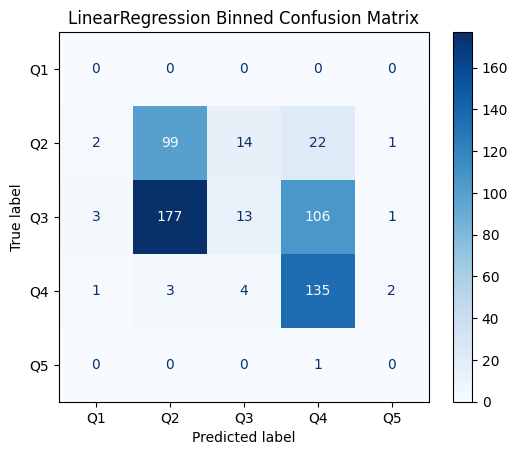


Training Ridge...
Ridge RMSE: 0.8053
Confusion Matrix (on binned target):
[[100  14  24   0]
 [177  13 110   0]
 [  4   4 137   0]
 [  0   0   1   0]]


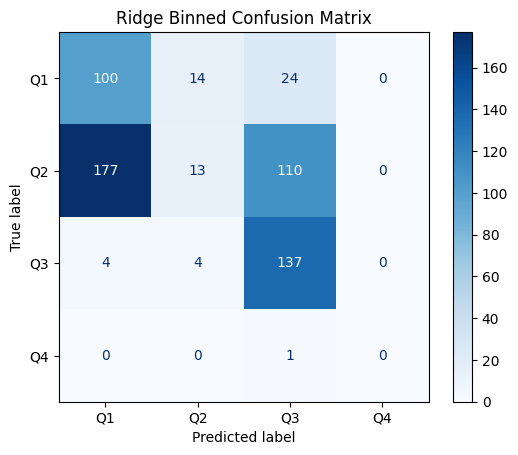


Training Lasso...
Lasso RMSE: 0.7879
Confusion Matrix (on binned target):
[[108  12  18   0]
 [174  18 108   0]
 [  1   5 139   0]
 [  0   0   1   0]]


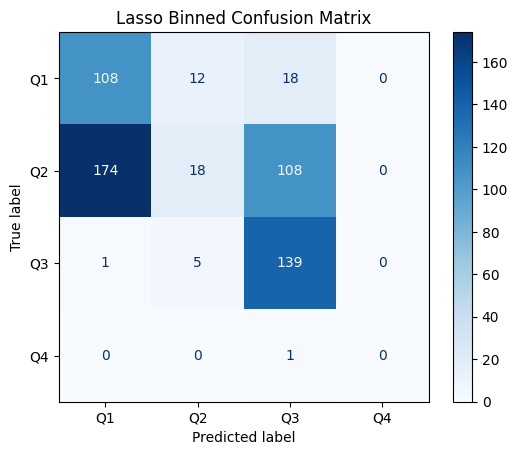


Training RandomForestRegressor...
RandomForestRegressor RMSE: 0.3914
Confusion Matrix (on binned target):
[[127   2   9   0]
 [179 118   3   0]
 [  7   4 134   0]
 [  0   0   1   0]]


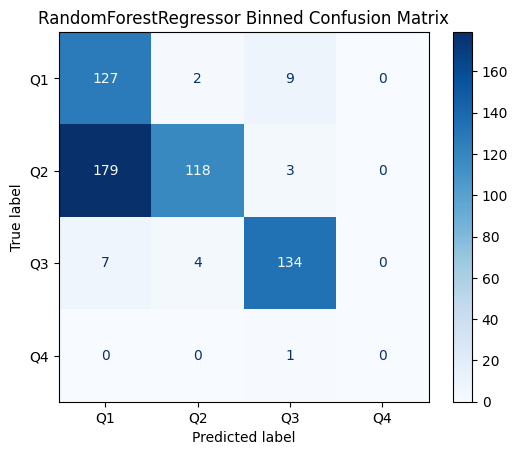


Training GradientBoostingRegressor...
GradientBoostingRegressor RMSE: 0.4182
Confusion Matrix (on binned target):
[[127   7   4   0]
 [168  91  41   0]
 [  9   8 128   0]
 [  0   0   1   0]]


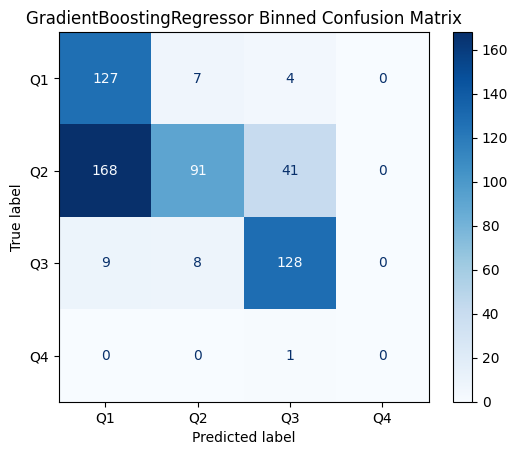


Training XGBRegressor...
XGBRegressor RMSE: 0.3754
Confusion Matrix (on binned target):
[[129   2   7   0]
 [161 122  17   0]
 [  6   6 133   0]
 [  0   0   1   0]]


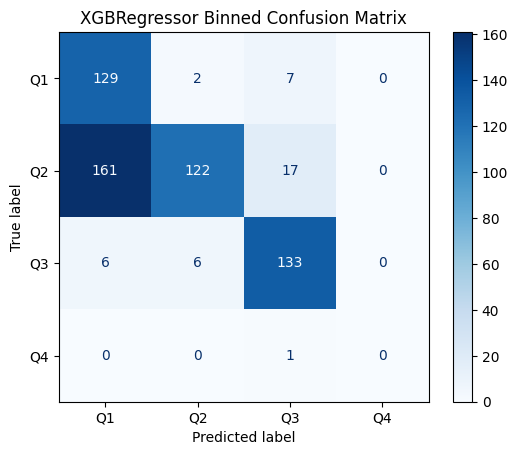

In [76]:
train_all_models(X_train_val, X_val, y_train, y_val)

In [77]:
import matplotlib.pyplot as plt

def plot_regression_results(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(12,5))
    
    # Actual vs Predicted
    plt.subplot(1,2,1)
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect prediction line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name}: Actual vs Predicted")
    
    # Residuals plot
    plt.subplot(1,2,2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5, color='green')
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{model_name}: Residuals")
    
    plt.show()


In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_regression_results(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(12,5))
    
    # Actual vs Predicted
    plt.subplot(1,2,1)
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # perfect prediction line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name}: Actual vs Predicted")
    
    # Residuals plot
    plt.subplot(1,2,2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5, color='green')
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{model_name}: Residuals")
    
    plt.show()

def evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"{model.__class__.__name__} RMSE: {rmse:.4f}")
    
    plot_regression_results(y_val, y_pred, model.__class__.__name__)



Training LinearRegression...
LinearRegression RMSE: 10119593543.9619


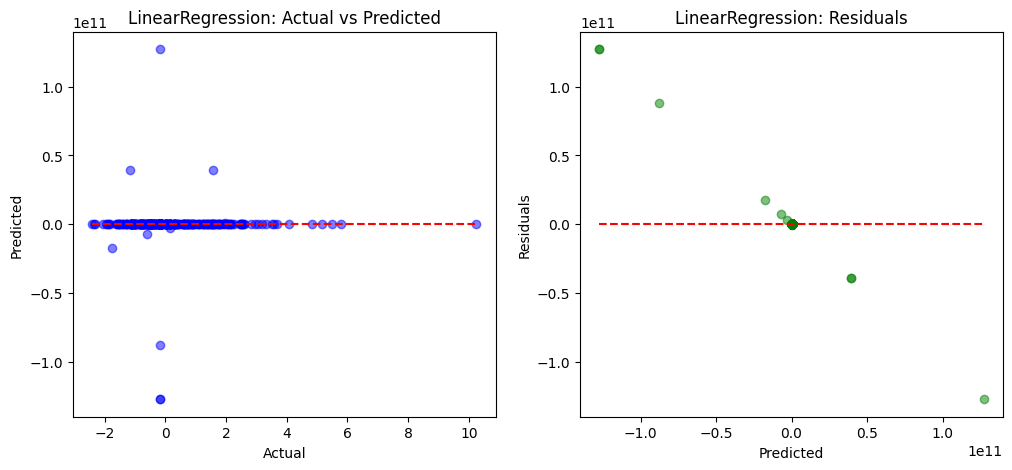


Training Ridge...
Ridge RMSE: 0.8053


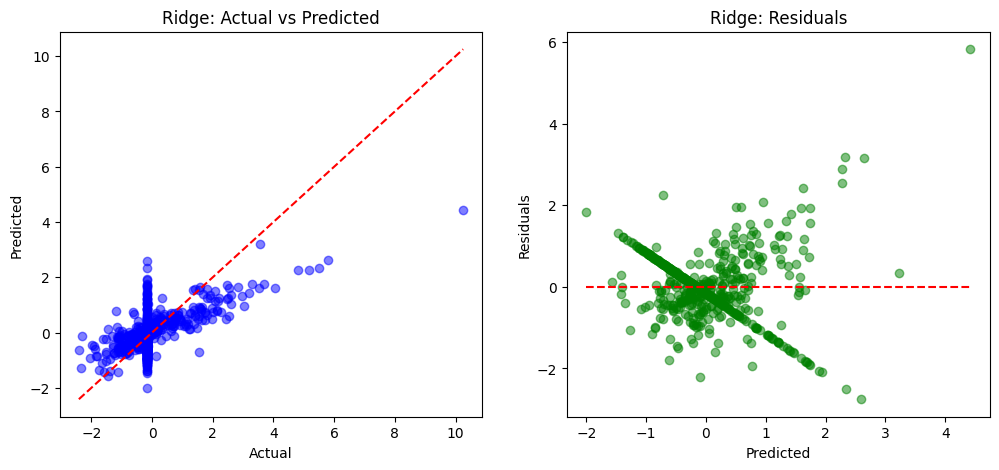


Training Lasso...
Lasso RMSE: 0.7879


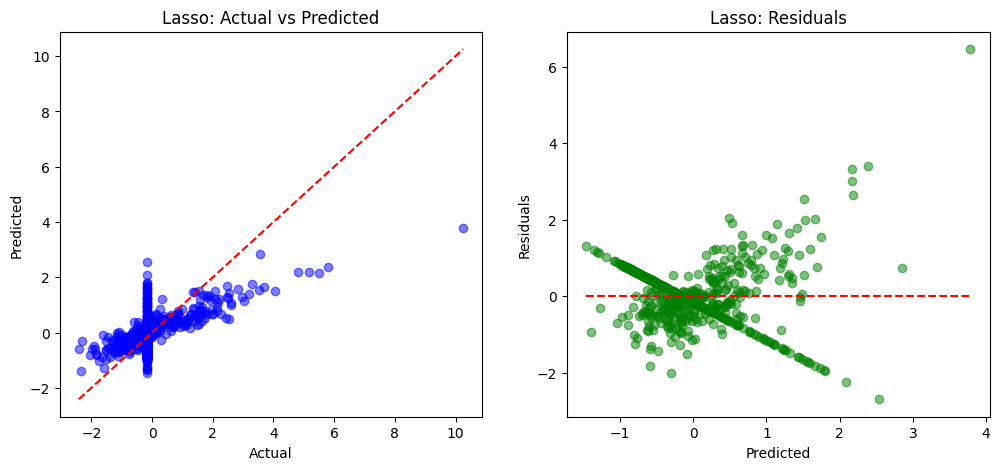


Training RandomForestRegressor...
RandomForestRegressor RMSE: 0.3914


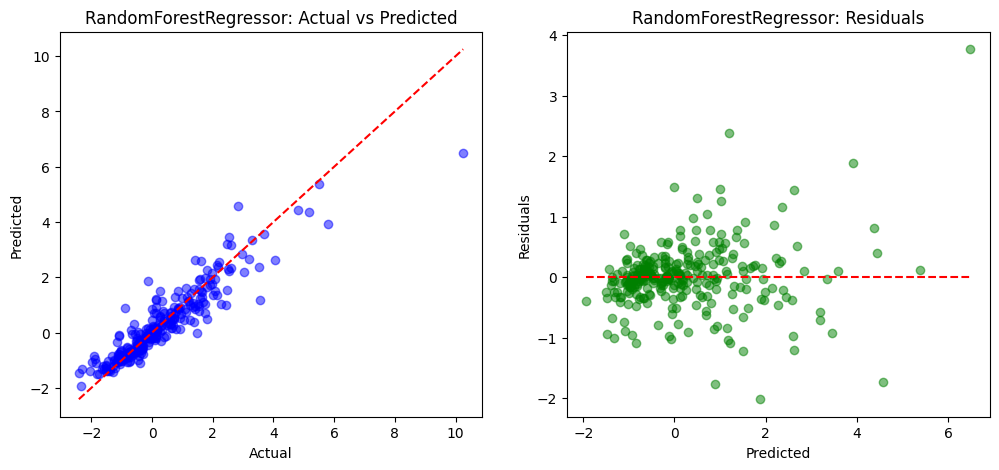


Training GradientBoostingRegressor...
GradientBoostingRegressor RMSE: 0.4182


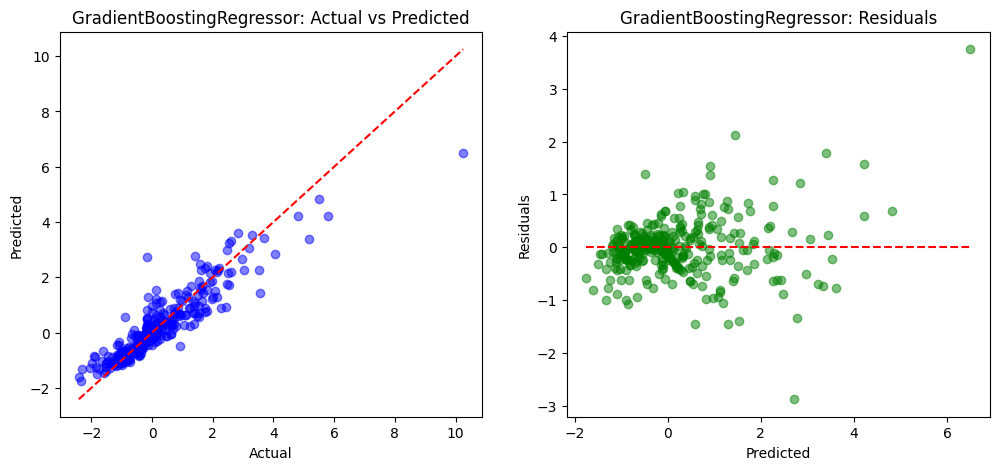


Training XGBRegressor...
XGBRegressor RMSE: 0.3754


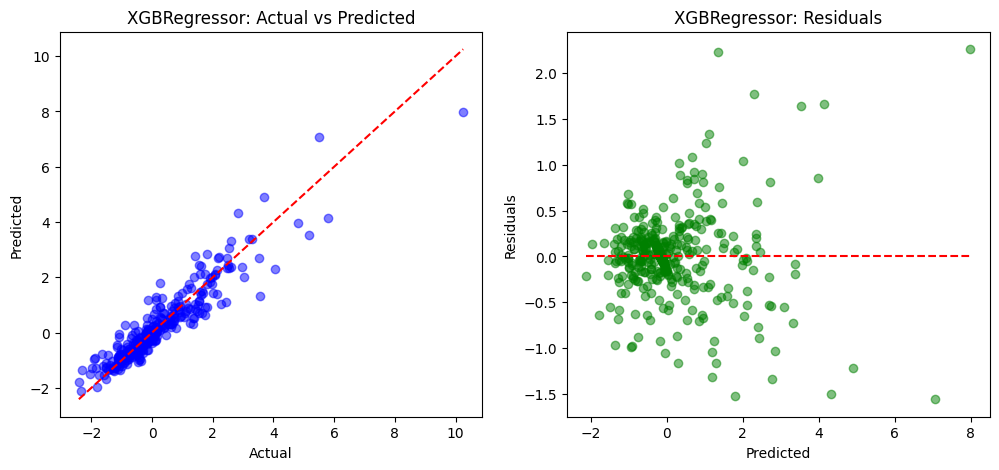

In [80]:
train_all_models(X_train_val, X_val, y_train, y_val)


In [42]:

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

X_train_val_clean, y_train_log_clean, X_val_clean, y_val_log_clean = clean_data(X_train_val, y_train_log, X_val, y_val_log)

evaluate_and_plot(ridge_model, X_train_val_clean, X_val_clean, y_train_log_clean, y_val_log_clean)


NameError: name 'ridge_model' is not defined

In [ ]:
import joblib
import pickle

# Assuming 'ridge_model' is your trained model instance

# Save with joblib
joblib.dump(ridge_model, 'ridge_model.joblib')

# Save with pickle
with open('ridge_model.pkl', 'wb') as f:
    pickle.dump(ridge_model, f)


In [ ]:
# Load with joblib
ridge_model_joblib = joblib.load('ridge_model.joblib')

# Load with pickle
with open('ridge_model.pkl', 'rb') as f:
    ridge_model_pickle = pickle.load(f)


In [ ]:
# List of selected features (example)
selected_numeric_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
    'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces',
    'BsmtFinSF1', 'LotArea', 'WoodDeckSF', 'OpenPorchSF',
    'HalfBath', '2ndFlrSF', 'ScreenPorch', 'PoolArea'
]

selected_categorical_features = [
    'Neighborhood', 'ExterQual', 'KitchenQual'  # example cat features if any
]

# Combine
selected_features = selected_numeric_features + selected_categorical_features


# Then proceed with splitting, preprocessing, training, as before:

X = train[selected_features]
y = train['SalePrice']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate numeric and categorical columns
numeric_cols = selected_numeric_features
categorical_cols = selected_categorical_features

# Preprocessing pipelines
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [ ]:
import numpy as np

# Define model with pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

# Fit model on log-transformed target
model.fit(X_train, np.log1p(y_train))

# Predict on validation set
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)  # inverse of log1p


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R^2: {r2:.4f}')



In [ ]:
import joblib

joblib.dump(model, 'ridge_model_selected_features.joblib')

